In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input/'):
    for filename in filenames:
        #print(os.path.join(dirname, filename))
        pass

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

note : this notebook is an open source project of ARJAN DE HAAN, I Made some modification on it, but it need more work

In [ ]:
# Install external requirements
!pip install -q imageio
!pip install -q git+https://github.com/tensorflow/docs
#!pip install -q discord-webhook
    
import os
import PIL
import glob
import time
import imageio

import numpy as np
import tensorflow as tf
from IPython import display
import matplotlib.pyplot as plt

# Import keras dependencies
from keras.layers import Input, Reshape, Dropout, Dense, Flatten, BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model, load_model
from keras.optimizers import Adam

WEBHOOK_URL = ''  # Insert the webhook url here
if WEBHOOK_URL:
    from discord_webhook import DiscordWebhook, DiscordEmbed
    DiscordWebhook(url=WEBHOOK_URL, content=f'Service started! gpu enabled: {tf.test.is_gpu_available()}').execute()
    

# Code that could prevent issues in the future
os.makedirs('/kaggle/temp/', exist_ok=True)

# Check if the gpu is enabled
print(f'GPU enabled: {tf.test.is_gpu_available()}')

# Explore Data Set

In [ ]:
import pandas as pd
data = pd.read_csv("/kaggle/input/nft-art-dataset/dataset/dataset.csv")

In [ ]:
data.shape

In [ ]:
data.head()

In [ ]:
data_path = '/kaggle/input/nft-art-dataset'

In [ ]:
# Reading an animated GIF file using Python Image Processing Library - Pillow

from PIL import Image

from PIL import GifImagePlugin

 

imageObject = Image.open(data_path + exp_img_path[1:])

print(imageObject.is_animated)

print(imageObject.n_frames)

 

# Display individual frames from the loaded animated GIF file

for frame in range(0,imageObject.n_frames):

    imageObject.seek(frame)

    imageObject.show()

In [ ]:
def readGif(filename, asNumpy=True):
    """ readGif(filename, asNumpy=True)
    
    Read images from an animated GIF file.  Returns a list of numpy 
    arrays, or, if asNumpy is false, a list if PIL images.
    
    """
    
    # Check PIL
    if PIL is None:
        raise RuntimeError("Need PIL to read animated gif files.")
    
    # Check Numpy
    if np is None:
        raise RuntimeError("Need Numpy to read animated gif files.")
    
    # Check whether it exists
    if not os.path.isfile(filename):
        raise IOError('File not found: '+str(filename))
    
    # Load file using PIL
    pilIm = PIL.Image.open(filename)    
    pilIm.seek(0)
    
    # Read all images inside
    images = []
    try:
        while True:
            # Get image as numpy array
            tmp = pilIm.convert() # Make without palette
            a = np.asarray(tmp)
            if len(a.shape)==0:
                raise MemoryError("Too little memory to convert PIL image to array")
            # Store, and next
            images.append(a)
            pilIm.seek(pilIm.tell()+1)
    except EOFError:
        pass
    
    # Convert to normal PIL images if needed
    if not asNumpy:
        images2 = images
        images = []
        for im in images2:            
            images.append( PIL.Image.fromarray(im) )
    
    # Done
    return images 

In [ ]:
from IPython.display import Image
Image(data_path + exp_img_path[1:], width=720, height=480)

# Training & data configuration

In [ ]:
# Changing this will mean you have to change a lot of other variables
# In the generator & the discriminator.
IMAGE_SIZE = (128,128) 

# Training settings
BUFFER_SIZE = 60000
BATCH_SIZE = 64 # Depends on the amount of memory available
EPOCHS = 2048
NOISE_DIM = 100  # Source https://arxiv.org/abs/1511.06434
GENERATE_RES = 3
NUM_EXAMPLES = 16  # Amount of images that will be shown in the progress gif

# Generate a gaussian random number seed which will be used to generate the gif.
seed = tf.random.normal([NUM_EXAMPLES, NOISE_DIM])

# Loading dataset into memory
You only need to run this once since it creates a npy file with the reshaped images.

## Image processing steps.
1. Find all images in the image directory.
2. Convert the image to RGB. Other image formats exists such as RGBA which have a different shape.
3. Reshape the image to the configured shape `IMAGE_SIZE`
4. Add the image to a big image list.
5. Convert the big list to a numpy array.
6. Convert all images to a float with the conventional length


In [ ]:
train_images = []
if os.path.isfile('/kaggle/working/image_data.npy'):
    # Load already converted images
    train_images = np.array(train_images)
else:
    # Convert images
    for image in glob.glob('/kaggle/input/nft-art-dataset/dataset/image/*'):
        im = PIL.Image.open(image) 
        
        # A convertion could be implemented but it is currently out of scope
        if im.mode != 'RGB': # Only accept RGB values.
            print(',', end='') # Show that it skipped an image
            continue
        im = im.resize(IMAGE_SIZE, PIL.Image.ANTIALIAS)
        train_images.append(np.array(im))
        print('.', end='') # This is added since the processing of data is rather slow & everyone likes visual progress :)
    print('\nDone')
    
    # convert the train_images array to an numpy array
    train_images = np.asarray(train_images)

    # Set the datatype of float
    print('Converting to float...')
    train_images = train_images.reshape(train_images.shape[0], IMAGE_SIZE[0], IMAGE_SIZE[1], 3).astype('float32')
    train_images = train_images / 127.5 - 1 # Convert to 0-1 range
    
    # Store images to a npy file so we don't have to redo this every time
    print('Saving image data...')
    np.save("/kaggle/working/image_data.npy", train_images)

In [ ]:
# Convert the data array to dataset & remove the array from memory
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
del train_images

## Create the generator model.
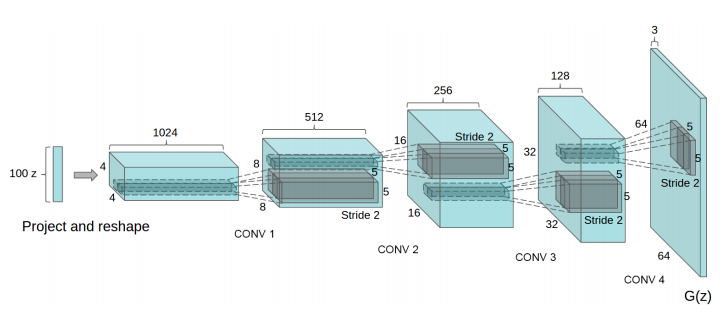

The generator model is the part of the model which generates images.

### Papers this model is based on
- Use ReLU to address the vanishing gradient problem [paper](https://arxiv.org/abs/1511.06434)
- Use Hyperbolic tangent in the output activation layer [paper](https://arxiv.org/abs/1511.06434)



In [ ]:
def make_generator_model():
    model = Sequential()
    model.add(Dense(4 * 4 * 256, activation="relu", input_dim=NOISE_DIM))
    model.add(Reshape((4, 4, 256)))
    model.add(UpSampling2D())
    model.add(Conv2D(256, kernel_size=3, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))
    model.add(UpSampling2D())
    model.add(Conv2D(256, kernel_size=3, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))
    for i in range(GENERATE_RES): # Some upscaling. This is not in the paper
        model.add(UpSampling2D())
        model.add(Conv2D(256, kernel_size=3, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Activation("relu"))
    model.summary()
    model.add(Conv2D(3, kernel_size=3, padding="same"))
    model.add(Activation("tanh"))
    input = Input(shape=(NOISE_DIM,))
    generated_image = model(input)
    return model

In [ ]:
generator = make_generator_model()

# Test the generator & show the image it created
noise = tf.random.normal([1, NOISE_DIM])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0])

# Create the Discriminator model
This is the model which tries to distinguish the generated images from the real images.

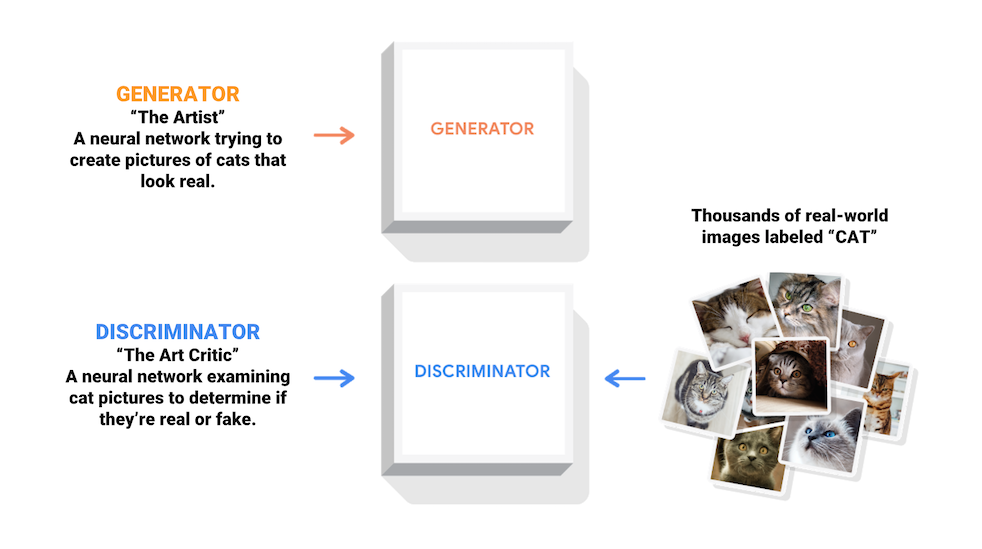

In [ ]:
def make_discriminator_model():
    model = Sequential()
    model.add(Conv2D(32, kernel_size=3, strides=2,
    input_shape=[IMAGE_SIZE[0], IMAGE_SIZE[1], 3], padding="same"))
    model.add(LeakyReLU(alpha=0.01))
    model.add(Dropout(0.25))
    model.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
    model.add(ZeroPadding2D(padding=((0, 1), (0, 1))))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.01))
    model.add(Dropout(0.25))
    model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.01))
    model.add(Dropout(0.25))
    model.add(Conv2D(256, kernel_size=3, strides=1, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.01))
    model.add(Dropout(0.25))
    model.add(Conv2D(512, kernel_size=3, strides=1, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.01))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    input_image = Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))
    validity = model(input_image)
    return Model(input_image, validity)

In [ ]:
discriminator = make_discriminator_model()

# Test the discriminator
decision = discriminator(generated_image)
print (decision)

Compute the loss of the discriminator & the generator

In [ ]:
# Compute the loss of the generator & the discriminator
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

Set the optimizer for the generator & discriminator

In [ ]:
# Set the optimizer for the generator & discriminator
generator_optimizer = Adam(0.001)
discriminator_optimizer = Adam(0.001)

Store training checkpoints in the temp directory


In [ ]:
checkpoint_dir = '/kaggle/temp/training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

# Store the current progress of the epoch
- On the harddrive to create gifs from
- On the cell to see the progress
- On discord to see the progress on another device

In [ ]:
def discord(epoch):
    webhook = DiscordWebhook(url=WEBHOOK_URL, content=f'Epoch {epoch}/{EPOCHS}')

    # set image
    #embed.set_image(url='/kaggle/temp/epoch_{:04d}.png'.format(epoch))
    with open('/kaggle/temp/epoch_{:04d}.png'.format(epoch), "rb") as f:
        webhook.add_file(file=f.read(), filename='image.jpg')

    response = webhook.execute()
    print(response)

# Store & show images every epoch
def generate_and_save_images(model, epoch, test_input):
    # Notice `training` is set to False.
    # This is so all layers run in inference mode (batchnorm).
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(4,4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0])
        plt.axis('off')

    plt.savefig('/kaggle/temp/epoch_{:04d}.png'.format(epoch))
    
    # send the progress to discord :)
    if WEBHOOK_URL:
        discord(epoch)
        
    plt.show()

In [ ]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, NOISE_DIM])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [ ]:
def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()

        for image_batch in dataset:
            train_step(image_batch)

        # Produce images for the GIF as we go
        display.clear_output(wait=True)
        generate_and_save_images(generator,
                                 epoch + 1,
                                 seed)

        # Save the model every 15 epochs
        if (epoch + 1) % 15 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)

        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))


In [ ]:
train(train_dataset, EPOCHS)

## Display training progress in a gif
Create a impressive animation of the training progress.

In [ ]:
def display_image(epoch_no):
    return PIL.Image.open('/kaggle/temp/epoch_{:04d}.png'.format(epoch_no))
display_image(EPOCHS)

In [ ]:
anim_file = '/kaggle/temp/dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('/kaggle/temp/epoch_*.png')
    filenames = sorted(filenames)
    
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

Embed the gif in the cell below

In [ ]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)

Show the generator test iamge once again to see improvements

In [ ]:
generated_image = generator(tf.random.normal([1, NOISE_DIM]), training=False)
plt.imshow(generated_image[0, :, :, 0], cmap)

## My opinion
I am not happy with my DCGAN progress. There could be a couple of things I can have done wrong. That could be tweaked to get better progress. But I'll let this project rest. I want to try some different GANs and see how they look like. If they all return poor images I'll use a different dataset.